In [1]:
import torch
import torchvision

print(f'Torch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

Torch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118


In [2]:
!pip install -q torchinfo

In [3]:
import matplotlib.pyplot as plt
from torchinfo import summary

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (3849/3849), done.
remote: Compressing objects: 100% (1571/1571), done.
remote: Total 3849 (delta 2255), reused 3752 (delta 2217), pack-reused 0
Receiving objects: 100% (3849/3849), 647.06 MiB | 31.95 MiB/s, done.
Resolving deltas: 100% (2255/2255), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path('data/')
image_path = data_path/ 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} directory exists')

else:
  print(f"{image_path} directory exists")
  image_path.mkdir(parents = True, exist_ok = True)

  with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
    rq = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f'Downloading pizza, steak, sushi data...')
    f.write(rq.content)

  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print(f'Unzipping pizza, steak, sushi data...')
    zip_ref.extractall(image_path)

  os.remove(data_path/'pizza_steak_sushi.zip')


data/pizza_steak_sushi directory exists
Unzipping pizza, steak, sushi data...


In [6]:
train_dir = image_path/'train'
test_dir = image_path/'test'

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# similar to
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = auto_transforms,
                                                                              batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bfcf877f370>,
 ['pizza', 'steak', 'sushi'])

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 80.0MB/s]


In [12]:
summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [13]:
model.features.parameters()

<generator object Module.parameters at 0x7bfcf8799d20>

In [14]:
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True)
).to(device)

In [16]:
summary(model,
        input_size = (32, 3, 224, 224),
        verbose = 0,
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[INFO] Total training time: 16.285 seconds


[INFO] Couldn't find helper_functions.py, downloading...


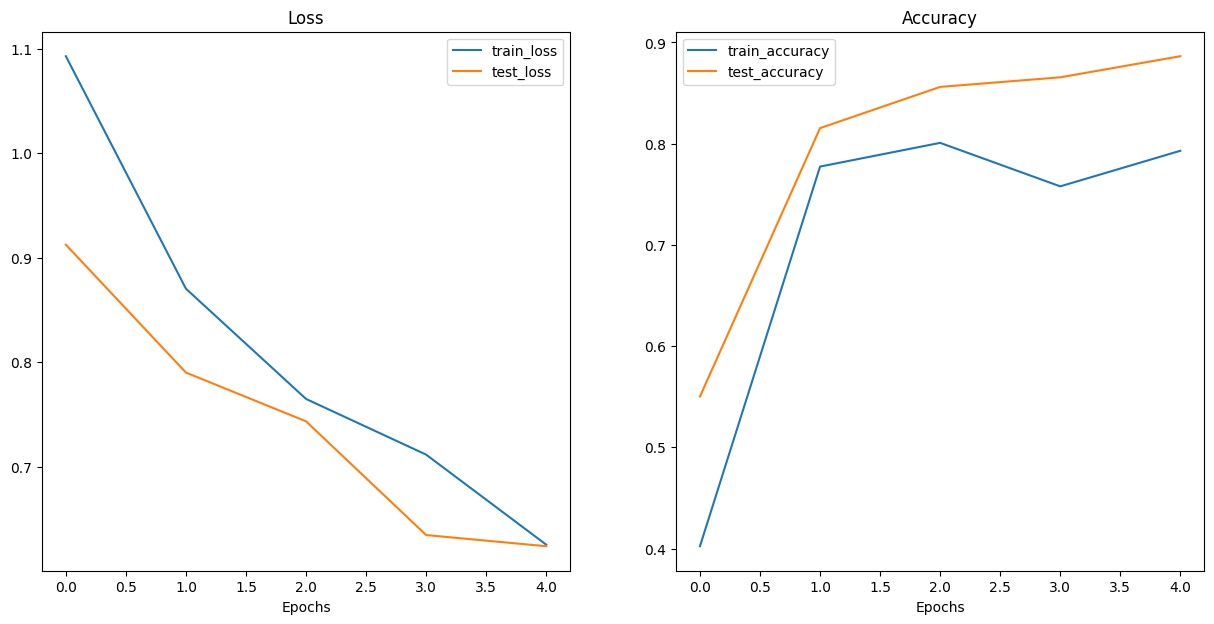

In [19]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

Ensure:
> Same shape  
> Same datatype  
> Same device  
> Same transformations  

In [25]:
from typing import List, Tuple
from PIL import Image
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
    ])

  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim = 0)
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
  plt.axis(False)

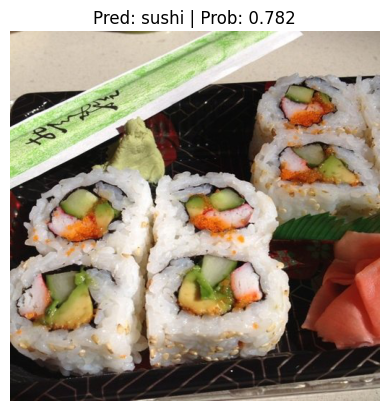

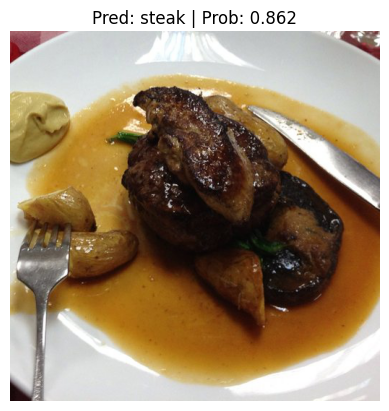

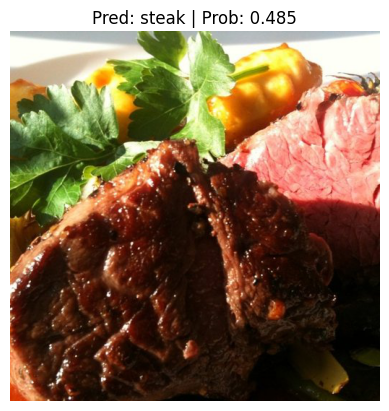

In [26]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))